In [93]:
import sys, traceback
import os
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from datetime import date, timedelta, datetime

In [94]:
sr_vis = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0, 'max': 0.3,} # for LANDSAT8 surface reflectance RGB

In [95]:
def scaled(image):  # for LANDSAT8 surfance reflectance
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

def select_bands(image): # select bands for training
    opticalBands = image.select('SR_B.')
    thermalRadianceBand = image.select('ST_TRAD')
    return image.addBands(opticalBands, None, True).addBands(thermalRadianceBand, None, True)

# Multi Cycle Sampling

In [28]:
# some sample cycles
cycle1 = scaled(ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210807"))
cycle2 = scaled(ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210823"))
cycle3 = scaled(ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210908"))
cycle4 = scaled(ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210924"))
cycles = [cycle1, cycle2, cycle3, cycle4]

In [96]:
Map = geemap.Map(center=(29.7662, -95.2410), zoom=9)
for cycle in cycles:
    Map.addLayer(cycle, sr_vis)
    Map.addLayer(cycle, sr_vis)
    Map.addLayer(cycle, sr_vis)
    Map.addLayer(cycle, sr_vis)
Map

AttributeError: 

The image argument in 'addLayer' function must be an instance of one of ee.Image, ee.Geometry, ee.Feature or ee.FeatureCollection.

In [33]:
print(geemap.image_props(cycle1).getInfo()['DATE_ACQUIRED'])

2021-08-07


In [31]:
print(geemap.image_props(cycle1).getInfo())

{'ALGORITHM_SOURCE_SURFACE_REFLECTANCE': 'LaSRC_1.5.0', 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE': 'st_1.3.0', 'CLOUD_COVER': 29.3, 'CLOUD_COVER_LAND': 28.85, 'COLLECTION_CATEGORY': 'T1', 'COLLECTION_NUMBER': 2, 'DATA_SOURCE_AIR_TEMPERATURE': 'MODIS', 'DATA_SOURCE_ELEVATION': 'GLS2000', 'DATA_SOURCE_OZONE': 'MODIS', 'DATA_SOURCE_PRESSURE': 'Calculated', 'DATA_SOURCE_REANALYSIS': 'GEOS-5 FP-IT', 'DATA_SOURCE_TIRS_STRAY_LIGHT_CORRECTION': 'TIRS', 'DATA_SOURCE_WATER_VAPOR': 'MODIS', 'DATE_ACQUIRED': '2021-08-07', 'DATE_PRODUCT_GENERATED': 1629326248000, 'DATUM': 'WGS84', 'EARTH_SUN_DISTANCE': 1.014096, 'ELLIPSOID': 'WGS84', 'GEOMETRIC_RMSE_MODEL': 7.996, 'GEOMETRIC_RMSE_MODEL_X': 5.388, 'GEOMETRIC_RMSE_MODEL_Y': 5.908, 'GEOMETRIC_RMSE_VERIFY': 6.421, 'GRID_CELL_SIZE_REFLECTIVE': 30, 'GRID_CELL_SIZE_THERMAL': 30, 'GROUND_CONTROL_POINTS_MODEL': 237, 'GROUND_CONTROL_POINTS_VERIFY': 71, 'GROUND_CONTROL_POINTS_VERSION': 5, 'IMAGE_DATE': '2021-08-07', 'IMAGE_QUALITY_OLI': 9, 'IMAGE_QUALITY_TIRS': 

In [34]:
dates = [geemap.image_props(cycle).getInfo()['DATE_ACQUIRED'] for cycle in cycles]
cloud_covers = [geemap.image_props(cycle).getInfo()['CLOUD_COVER'] for cycle in cycles]
print(dates)
print(cc)

['2021-08-07', '2021-08-23', '2021-09-08', '2021-09-24']
[29.3, 3.91, 5.04, 0.61]


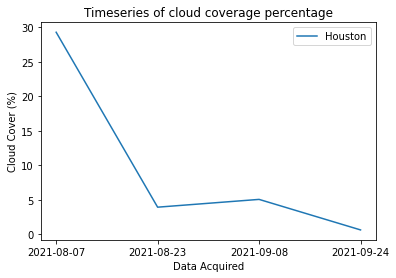

In [44]:
from matplotlib import pyplot as plt
plt.plot(dates, cc, label="Houston")
plt.title("Timeseries of cloud coverage percentage")
plt.xlabel("Data Acquired")
plt.ylabel("Cloud Cover (%)")
plt.legend()
plt.show()


In [53]:
# date calculator
now = datetime.strptime('20210807', '%Y%m%d')
print(now.strftime('%Y%m%d'))
future = now + timedelta(days=16)
print(future.strftime('%Y%m%d'))
    

20210807
20210823


# Multi Cycle Sampling with date genration

In [34]:
NUM_DATES = 30
START_DATE = None
REFERENCE_DATE = '20210807'
NULLIFY_DATES_AFTER = '20220101'

In [71]:
class Suppressor(object):
    
    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self

    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
        if type is not None:
            raise

    def write(self, x): pass

    
def verify_date(date_str: str, suppressOutput=False) -> bool:
    date = datetime.strptime(date_str, '%Y%m%d')
    nullified_date = datetime.strptime(NULLIFY_DATES_AFTER, '%Y%m%d')
    if (date - nullified_date).days >=0:
        if not suppressOutput: 
            print(f'Invalid date encountered: {date_str}. Need to specify a date before {NULLIFY_DATES_AFTER}')
        return False
    else:
        time_delta = datetime.strptime(REFERENCE_DATE, '%Y%m%d') - date
        r = time_delta.days % 16
        if r == 0:
            return True
        else:
            if not suppressOutput: 
                print(f'Date {date_str} is not valid for the selected region. Consider adding {r} days.')
            return False


def calc_num_cycles(start_date_str: str, end_date_str: str) -> int:
    b1 = verify_date(start_date_str)
    b2 = verify_date(end_date_str)
    if (not b1) or (not b2):
        raise AttributeError('ERROR: invalid dates encountered')
    start_date = datetime.strptime(start_date_str, '%Y%m%d')
    end_date = datetime.strptime(end_date_str, '%Y%m%d')
    date_delta = int((end_date - start_date).days / 16)
    return date_delta


def find_next_valid_date(date_str: str, strictly_next=False) -> str:
    date = datetime.strptime(date_str, '%Y%m%d')
    if verify_date(date_str, suppressOutput=True):  # current date is a valid date
        if not strictly_next:
            return date_str
        else:
            r = 16
    else:  # current date is not a valid date
        time_delta = datetime.strptime(REFERENCE_DATE, '%Y%m%d') - date
        r = time_delta.days % 16
    next_valid_time = date + timedelta(days=r)
    next_valid_date = next_valid_time.strftime('%Y%m%d')
    assert verify_date(next_valid_date), f"ERROR: Unable to find a next valid date after {date_str}"
    return next_valid_date

def generate_cycles(start_date: str, end_date=None, num_days=None, num_cycles=None):
    param_error_msg = "only allowed to specify exactly one of end_date, num_days, or num_cycles"
    if end_date is not None:
        assert num_days is None and num_cycles is None, param_error_msg
        raise NotImplementedError()
    elif num_days is not None:
        assert end_date is None and num_cycles is None, param_error_msg
        raise NotImplementedError()
    elif num_cycles is not None:
        assert end_date is None and num_days is None, param_error_msg
        assert num_cycles >= 1, "Numer of cycles have to be >= 1"
        cycles = []
        cur_date = find_next_valid_date(start_date)
        for cycle in range(num_cycles):
            cycles.append(cur_date)
            cur_date = find_next_valid_date(cur_date, strictly_next=True)
    
    print(f'Generated {len(cycles)} cycles, with start date = {cycles[0]} and end tate = {cycles[-1]}')
    return cycles

# Cloud coverage timeseries

In [102]:
cycles = generate_cycles(start_date='20180101', num_cycles=50)

Generated 50 cycles, with start date = 20180103 and end tate = 20200226


In [121]:
imgs = []
invalid_ids = ['LANDSAT/LC08/C02/T1_L2/LC08_025039_20180204', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20180220', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20180324', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20181119', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20190122', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20190223', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20190919', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20191122', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20200109', 'LANDSAT/LC08/C02/T1_L2/LC08_025039_20200210']
for date_ in cycles:
    id_ = f"LANDSAT/LC08/C02/T1_L2/LC08_025039_{date_}"
    if id_ in invalid_ids:
        continue
    img = scaled(ee.Image(id_))
    if img is not None:
        imgs.append(img)
dates = [geemap.image_props(img).getInfo()['DATE_ACQUIRED'] for img in imgs]
cloud_covers = [geemap.image_props(img).getInfo()['CLOUD_COVER'] for img in imgs]
print(dates)
print(cloud_covers)

['2018-01-03', '2018-01-19', '2018-03-08', '2018-04-09', '2018-04-25', '2018-05-11', '2018-05-27', '2018-06-12', '2018-06-28', '2018-07-14', '2018-07-30', '2018-08-15', '2018-08-31', '2018-09-16', '2018-10-02', '2018-10-18', '2018-11-03', '2018-12-05', '2018-12-21', '2019-01-06', '2019-02-07', '2019-03-11', '2019-03-27', '2019-04-12', '2019-04-28', '2019-05-14', '2019-05-30', '2019-06-15', '2019-07-01', '2019-07-17', '2019-08-02', '2019-08-18', '2019-09-03', '2019-10-05', '2019-10-21', '2019-11-06', '2019-12-08', '2019-12-24', '2020-01-25', '2020-02-26']
[0.06, 87.15, 82.9, 93.17, 0.27, 25.01, 34.26, 20.6, 29.31, 22.13, 99.03, 31.61, 27.2, 5.4, 24.78, 85.11, 10.43, 2.58, 0.04, 11.29, 88.42, 99.94, 0.61, 83.61, 36.15, 1.49, 66.72, 28.99, 18.18, 30.3, 36.33, 31.77, 25, 1.46, 63.02, 9.49, 61.66, 0.06, 79.26, 61.42]


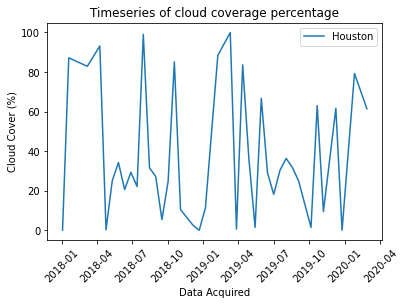

In [125]:
from matplotlib import pyplot as plt
dates2 = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates]

plt.plot(dates2, cloud_covers, label="Houston")
plt.title("Timeseries of cloud coverage percentage")
plt.xlabel("Data Acquired")
plt.ylabel("Cloud Cover (%)")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [126]:
print(f'average cloud coverage = {np.mean(cloud_covers)}')

average cloud coverage = 37.90525


# Adding bitmap for cloud coverage

In [191]:
def scaled_cloud(image):
    cloudBands = image.select('ST_CDIST').multiply(0.01)
    return image.addBands(cloudBands, None, True)

max_ = 1e-7
sample_tile = ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210807")
left_layer = geemap.ee_tile_layer(scaled(sample_tile).select(['SR_B4', 'SR_B3', 'SR_B2']), {'min': 0.0, 'max': 0.3,}, 'Landsat8')
right_layer = geemap.ee_tile_layer(scaled_cloud(sample_tile).select(['ST_CDIST']), {'min': 0.0, 'max': max_,}, 'Cloud Distance')
Map = geemap.Map(center=(29.7662, -95.2410), zoom=9)
Map.split_map(left_layer=left_layer, right_layer=right_layer)
Map.add_colorbar({'min': 0.0, 'max': max_,}, label="Pixel Distance To Cloud")
Map

Map(center=[29.7662, -95.241], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [175]:
geemap.image_props(ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_025039_20210807")).getInfo()['CLOUD_COVER']

29.3